# Blackbird Force Estimation

The blackbird position estimation is currently taken from the camera system at ~360 Hz. Using the position information, this notebook will look at various ways to numerically estimate the velocity and acceleration along the flight test.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../functions'))
import read_blackbird_dataset as rbd

test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)

In [2]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216365 entries, 1526617312016142000 to 1526617526753759000
Data columns (total 37 columns):
PWM1                              39823 non-null float64
PWM2                              39823 non-null float64
PWM3                              39823 non-null float64
PWM4                              39823 non-null float64
angular_velocity_covariance       21298 non-null object
ax_[m/s2]                         21298 non-null float64
ay_[m/s2]                         21298 non-null float64
az_[m/s2]                         21298 non-null float64
linear_acceleration_covariance    21298 non-null object
omegax_[dps]                      21298 non-null float64
omegay_[dps]                      21298 non-null float64
omegaz_[dps]                      21298 non-null float64
orientation_covariance            21298 non-null object
pitch_[rad]                       77286 non-null float64
pitch_ref_[rad]                   38130 non-null float64
px_[m]

<IPython.core.display.Javascript object>


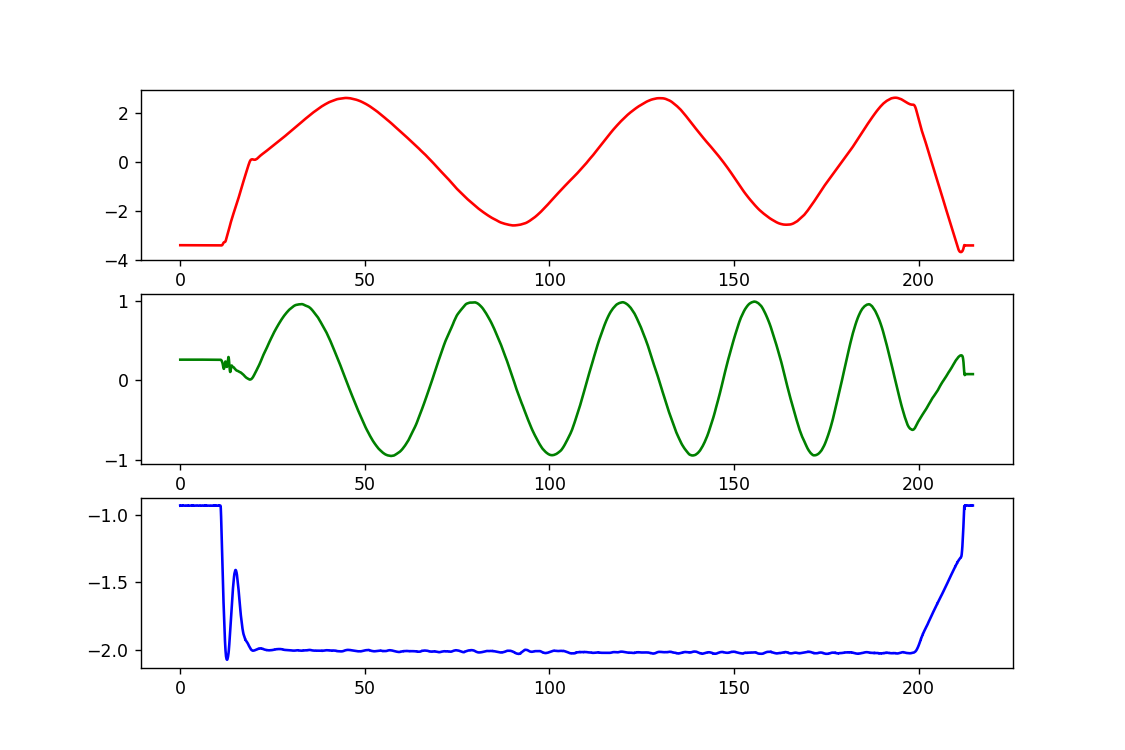

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

rbts2s = 10 ** -9
tvec = (test_df.index - test_df.index[0])*rbts2s

fig, ax = plt.subplots(3,1)
fig.set_size_inches(9,6)
ax[0].plot(tvec, test_df['px_[m]'], color='r')
ax[1].plot(tvec, test_df['py_[m]'], color='g')
ax[2].plot(tvec, test_df['pz_[m]'], color='b')

plt.show()

In [4]:
# Numpy second order central difference
import numpy as np

px = test_df['px_[m]'].values
py = test_df['py_[m]'].values
pz = test_df['pz_[m]'].values

vx = np.gradient(px, tvec)
vy = np.gradient(py, tvec)
vz = np.gradient(pz, tvec)

vmag = (vx**2 + vy**2 + vz**2) ** (1/2)

<IPython.core.display.Javascript object>


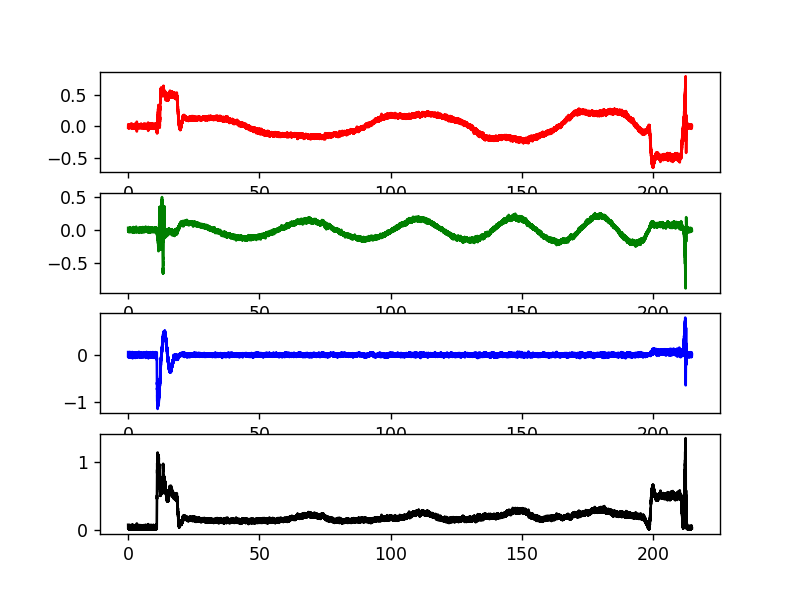

In [5]:
fig, ax = plt.subplots(4,1)

ax[0].plot(tvec, vx, color='r')
ax[1].plot(tvec, vy, color='g')
ax[2].plot(tvec, vz, color='b')
ax[3].plot(tvec, vmag, color='k')

plt.show()

In [6]:
# Numpy second order central difference

ax = np.gradient(vx, tvec)
ay = np.gradient(vy, tvec)
az = np.gradient(vz, tvec)

amag = (ax**2 + ay**2 + az**2) ** (1/2)
print(ax.shape)
print(tvec.shape)

(216365,)
(216365,)


<IPython.core.display.Javascript object>


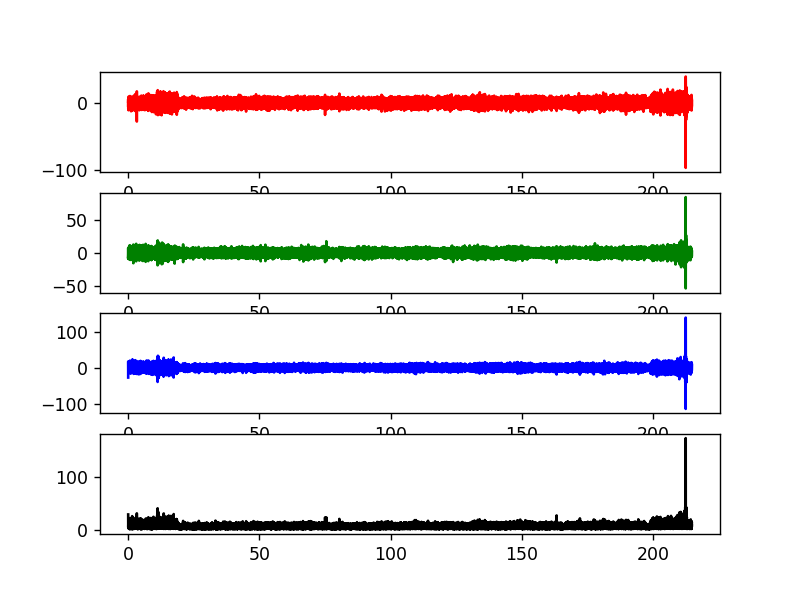

In [7]:
fig, axis = plt.subplots(4,1)

axis[0].plot(tvec, ax, color='r')
axis[1].plot(tvec, ay, color='g')
axis[2].plot(tvec, az, color='b')
axis[3].plot(tvec, amag, color='k')

plt.show()

In [61]:
import math
import copy

def lsee_polynomial_extrapolate(tvec, x, tpred, m):
    """
    Uses the known points to fit a least squares polynomial and then extrapolates it to a predition interval
    """
    pn = tpred.shape[0] #number of prediction points
    dmdxm = np.zeros((pn, m+1))
    
    # Get coefficients
    X = np.outer(tvec, np.ones((m+1,))) # x (m+1)
        # creating rows of [t^0, t^1, ..., t^m]
    for j in range(m+1):
        X[:,j] = X[:,j] ** j
    Xt = np.transpose(X) #(m+1) x ws
    #Least squares solution (m+1)x1
    theta = np.matmul(np.linalg.inv(np.matmul(Xt,X)),
                      np.matmul(Xt, np.transpose(x)))
    
    #For prediction interval
    Xp  = np.outer(tpred, np.ones((m+1,)))
    for j in range(m+1):
        Xp[:,j] = Xp[:,j] ** j
    #Start populating the prediction
    diff_multiplier = list(range(1,m+1))
    for i in range(m+1):
        dmdxm[:,i] = np.matmul(Xp, theta)
        if i != m:
            Xp = Xp[:,:-1]
            theta = theta[1:]*diff_multiplier
            diff_multiplier = diff_multiplier[:-1]
    
    return dmdxm

# Creating function for arbitary polynomial fitting
def central_sg_filter(tvec, xvec, m=5, window=13):
    """
    Based off the Savitzky-Golay filter which uses a least-squares estimation to determine a local polynomial. 
    
    Parameters:
        tvec   = (n,) numpy array for time vector which is not uniform
        xvec   = (n,) numpy array of the noise time
        m      = mth order polynomial
        window = number of points to be looking at. Should be odd so that the smoothing is being done 
                [-(j-1)/2,...,-1,0,1,...,(j-1)/2]
    
    Output:
        dmdxm = (n,m+1) vector of 0th to mth derivatives
        
    Reference: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    
    #Initialize vectors
    n     = tvec.shape[0] #Length of x vector
    dmdxm = np.zeros((n,m+1)) #n x (m+1) matrix of the ith derivative
    hs    = int((window - 1)/2) #Half window size
    
    #Conversion between polynomial coefficients and the derivatives
    diff_multipliers = np.ones(m+1)
    mfact = math.factorial(m)
    for i in range(m+1):
        diff_multipliers[i] = math.factorial(i)
    
    #Middle sections (i.e. central estimations)
    for i in range(hs, n-hs):
        tlocal = tvec[i-hs:i+hs+1] - tvec[i]
        y      = xvec[i-hs:i+hs+1] #1 x ws
        X = np.outer(tlocal, np.ones((m+1,))) #ws x (m+1)
        # creating rows of [t^0, t^1, ..., t^m]
        for j in range(m+1):
            X[:,j] = X[:,j] ** j
        Xt = np.transpose(X) #(m+1) x ws
        
        try:
            #Least squares solution (m+1)x1
            XtXinv = np.linalg.inv(np.matmul(Xt,X))
            theta = np.matmul(XtXinv, np.matmul(Xt, np.transpose(y)))
        except np.linalg.LinAlgError as err:
            #exact solution
            X = X[:(m+1), :(m+2)] #Get a square matrix
            theta = np.matmul(np.linalg.inv(X), np.transpose(y[:(m+1)]))
            
        dmdxm[i,:] = np.transpose(theta)*diff_multipliers
    
    #Beginning and ending sections
    for (i0, index) in zip([hs, n-hs-1], [list(range(hs)), list(range(n-hs,n))]):
        
        t0        = tvec[i0] #zeroth time
        t_predict = tvec[index] - t0 # 1 x (window - 1)/2
        
        if i0 < n/2:
            i_train = list(range((i0+1),(i0+window+2)))
        else:
            i_train = list(range((i0-window-1),i0))
        
        t_train = tvec[i_train] - t0
        x_train = xvec[i_train]
        dmdxm[index,:] = lsee_polynomial_extrapolate(t_train, x_train, t_predict, m)
        
        """
        #dmdxm0 = dmdxm[i0,:] #all coefficients at the zeroth time
        #Trying to average the extrapolation coefficients
        if i0 > index[0]:
            dmdxm0 = copy.deepcopy(dmdxm[i0:(i0+hs+1),:])
            nt     = t0 - tvec[i0:(i0+hs+1)]
        else:
            dmdxm0 = copy.deepcopy(dmdxm[(i0-hs):(i0+1), :])
            nt     = t0 - tvec[(i0-hs):(i0+1)]
        print(dmdxm0)
        for i in range(1,m+1):
            for j in range(1,i+1):
                dmdxm0[:, -(i+1)] = dmdxm0[:, -(i+1)] + dmdxm0[:,-(i-j+1)]*(nt ** j)/math.factorial(j)
                print(nt)
                print(dmdxm0)
        dmdxm0 = np.mean(dmdxm0, axis=0)
        print(dmdxm0)
        
        #Estimate all derivatives in the end zones
        for i in range(m+1):
            if i == 0:
                dmdxm[index, -1] = dmdxm0[-1]
            #Should be a way to change this loop to matrix math with concatenation
            else:
                for j in range(i+1):
                    dmdxm[index, -i-1] = dmdxm[index, -i-1] +\
                                         dmdxm0[-(i-j+1)]*(tlocal ** j)/math.factorial(j)
        """
    return dmdxm

<IPython.core.display.Javascript object>


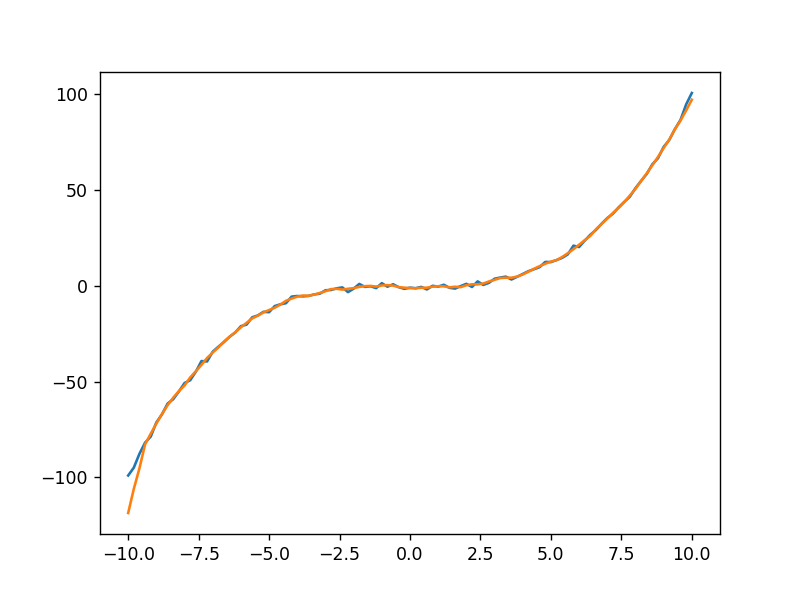

In [48]:
#Testing/debugging the filter above
# Simple case f(x) = a*x^3 + b*e where e ~ N(0,1)
n = 101
x = np.linspace(-10, 10, num=n)
f = 0.1*(x ** 3) + 1*np.random.randn(n)

dmdxm = central_sg_filter(x,f,m=3, window=7)

fig, axis = plt.subplots(1,1)
axis.plot(x,f)
axis.plot(x,dmdxm[:,0])

plt.show()

<IPython.core.display.Javascript object>


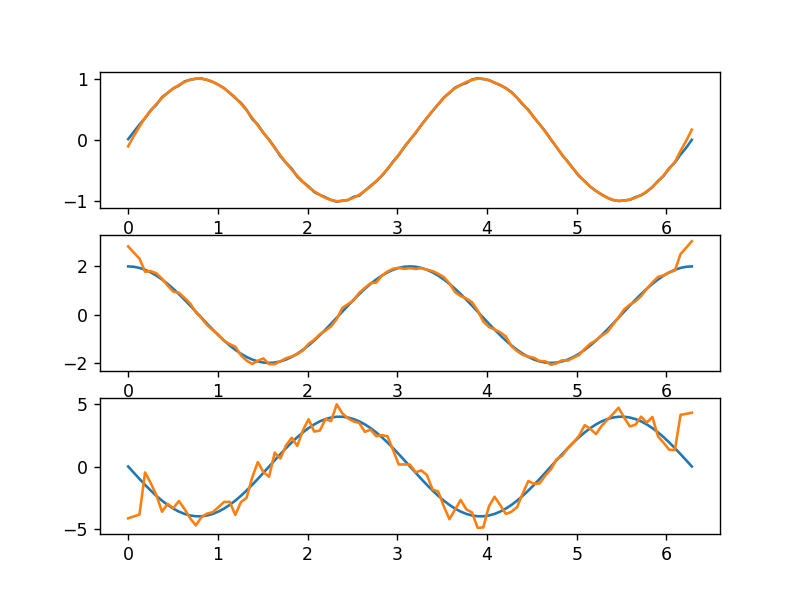

In [62]:
#Trying on sinosodal waves to determine behavior
# Simple case f(x) = a*x^3 + b*e where e ~ N(0,1)
n = 101
x = np.linspace(0, 2*np.pi, num=n)
f = np.sin(2*x) + .01*np.random.randn(n)

dmdxm = central_sg_filter(x,f,m=3, window=7)

fig, axis = plt.subplots(3,1)

axis[0].plot(x,f)
axis[0].plot(x,dmdxm[:,0])
axis[1].plot(x,2*np.cos(2*x))
axis[1].plot(x,dmdxm[:,1])
axis[2].plot(x,-4*np.sin(2*x))
axis[2].plot(x,dmdxm[:,2])

plt.show()

<IPython.core.display.Javascript object>


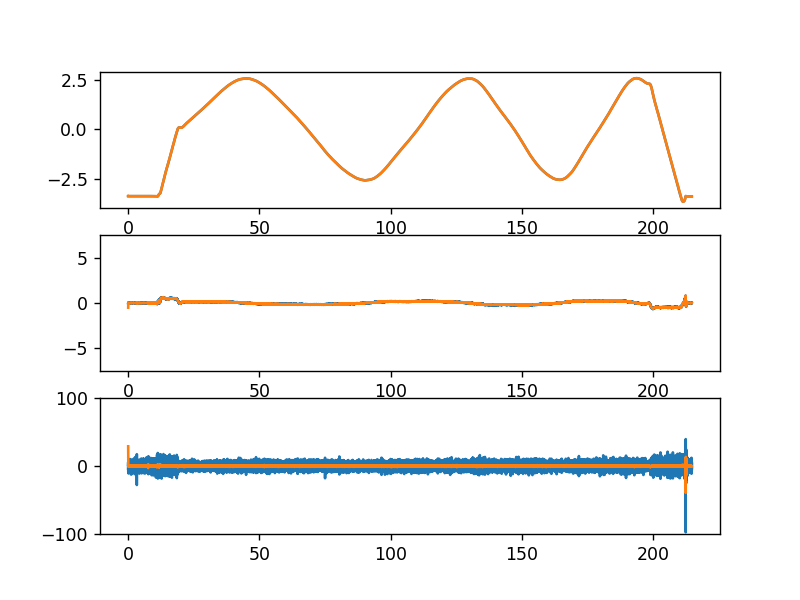

In [63]:
# Testing on x axis values
px_est = central_sg_filter(tvec, px, m=5, window=27)

fig, axis = plt.subplots(3,1)

axis[0].plot(tvec, px)
axis[0].plot(tvec, px_est[:,0])
axis[1].plot(tvec, vx)
axis[1].plot(tvec, px_est[:,1])
axis[1].set_ylim(-7.5, 7.5)
axis[2].plot(tvec, ax)
axis[2].plot(tvec, px_est[:,2])
axis[2].set_ylim(-100, 100)

plt.show()